# Experience Analytics

The main aim of this section is to focus on network parameters like TCP retransmission, Round Trip Time (RTT), Throughput, and the customers’ device characteristics like the handset type to conduct a deep user experience analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn import preprocessing
from scipy import stats
from sklearn.cluster import KMeans
import sklearn.cluster as cluster
import scipy.spatial.distance as sdist

import sys

In [2]:
data = pd.read_csv('data/clean_data.csv',low_memory=False)
data = data.drop(['Unnamed: 0'], axis=1)
data['Number of sessions'] = 1

In [3]:
a = data.copy()
a['Handset'] = a[['MSISDN/Number', 'Handset Type', 'Start ms', 'End ms', 'Dur. (ms)', 'IMSI', 
                     'IMEI','Avg RTT DL (ms)','Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)','Avg Bearer TP UL (kbps)',
                     'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)','DL TP < 50 Kbps (%)',
                     '50 Kbps < DL TP < 250 Kbps (%)','250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
                     'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)','50 Kbps < UL TP < 300 Kbps (%)', 
                     'UL TP > 300 Kbps (%)','HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
                     'Activity Duration UL (ms)', 'Dur. (ms).1','Nb of sec with 125000B < Vol DL',
                     'Nb of sec with 1250B < Vol UL < 6250B','Nb of sec with 31250B < Vol DL < 125000B',
                     'Nb of sec with 37500B < Vol UL','Nb of sec with 6250B < Vol DL < 31250B',
                     'Nb of sec with 6250B < Vol UL < 37500B','Nb of sec with Vol DL < 6250B', 'Nb of sec with Vol UL < 1250B',
                     'Social Media DL (Bytes)', 'Social Media UL (Bytes)','Google DL (Bytes)', 'Google UL (Bytes)', 
                     'Email DL (Bytes)','Email UL (Bytes)', 'Youtube DL (Bytes)', 'Youtube UL (Bytes)','Netflix DL (Bytes)', 
                     'Netflix UL (Bytes)', 'Gaming DL (Bytes)','Gaming UL (Bytes)', 'Other DL (Bytes)', 'Other UL (Bytes)',
                     'Total UL (Bytes)', 'Total DL (Bytes)', 'Number of sessions']].groupby(by=['MSISDN/Number'])['Handset Type'].transform(lambda x: ','.join(x))
a = a.drop_duplicates()
b = a.groupby(by = ['MSISDN/Number'], as_index = False).agg('sum')
b = a[['MSISDN/Number','Handset']]

In [4]:
b = b.groupby(by = ['MSISDN/Number'], as_index = False).agg({'Handset': ' '.join})
c = data.groupby(by = ['MSISDN/Number'], as_index = False).agg('sum')
data = pd.merge(c,b, on='MSISDN/Number',how = 'right' ) 

In [5]:
all_columns = list(data.iloc[:,1:].columns)
for x in all_columns:
    try:
        data[x] = np.where(data[x] > data[x].quantile(0.95), data[x].quantile(0.50), data[x])
    except TypeError:
        continue

In [6]:
data = data[['MSISDN/Number','Number of sessions','Handset', 'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)','Avg RTT DL (ms)', 'Avg RTT UL (ms)','Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)']]

In [7]:
data['Average TCP (Gigabytes)'] = (data['TCP DL Retrans. Vol (Bytes)'] + data['TCP UL Retrans. Vol (Bytes)'])/(1e+9)
data = data.drop(['TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)'], axis=1)

data['Average RTT (ms)'] = (data['Avg RTT DL (ms)'] + data['Avg RTT UL (ms)'])
data = data.drop(['Avg RTT DL (ms)', 'Avg RTT UL (ms)'], axis=1)

data['Average throughput (gbps)'] = (data['Avg Bearer TP DL (kbps)'] + data['Avg Bearer TP UL (kbps)'])/1e+6
data = data.drop(['Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)'], axis=1)


In [8]:
tcp = data[['MSISDN/Number','Average TCP (Gigabytes)','Number of sessions','Handset']].sort_values(by=['Average TCP (Gigabytes)'],ascending=False)
rtt = data[['MSISDN/Number','Average RTT (ms)','Number of sessions','Handset']].sort_values(by=['Average RTT (ms)'],ascending=False)
thru = data[['MSISDN/Number','Average throughput (gbps)','Number of sessions','Handset']].sort_values(by=['Average throughput (gbps)'],ascending=False)

In [9]:
tcp_top = list(tcp['MSISDN/Number'].head(10))
tcp_bottom = list(tcp['MSISDN/Number'].tail(10))
tcp_freq = tcp.sort_values(['Number of sessions','Average TCP (Gigabytes)'],ascending=False).head(10)
tcp_freq = list(tcp_freq['MSISDN/Number'])

In [10]:
rtt_top = list(rtt['MSISDN/Number'].head(10))
rtt_bottom = list(rtt['MSISDN/Number'].tail(10))
rtt_freq = rtt.sort_values(['Number of sessions','Average RTT (ms)'],ascending=False).head(10)
rtt_freq = list(rtt_freq['MSISDN/Number'])

In [11]:
thru_top = list(thru['MSISDN/Number'].head(10))
thru_bottom = list(thru['MSISDN/Number'].tail(10))
thru_freq = thru.sort_values(['Number of sessions','Average throughput (gbps)'],ascending=False).head(10)
thru_freq = list(thru_freq['MSISDN/Number'])

#### Distribution of the average throughput per handset type

In [12]:
hand_thru = thru[['Average throughput (gbps)','Handset']]
hand_thru = hand_thru.groupby(['Handset'],as_index=False).agg('sum').sort_values(['Average throughput (gbps)'],ascending=False)

#### Average TCP retransmission view per handset type

In [13]:
hand_tcp = tcp[['Average TCP (Gigabytes)','Handset']]
hand_tcp = hand_tcp.groupby(['Handset'],as_index=False).agg('sum').sort_values(['Average TCP (Gigabytes)'],ascending=False)

In [14]:
data = data.drop(['Handset'], axis=1)

In [15]:
#function to normalize dataset
def normalize(dataset):
    un_dataset = dataset.iloc[:,1:].values
    min_max_scaler = preprocessing.MinMaxScaler()
    dataset_scaled = min_max_scaler.fit_transform(un_dataset)
    n_dataset = pd.DataFrame(dataset_scaled,columns =[dataset.iloc[:,1:].columns] )
    return n_dataset

In [16]:
#initialization of K-means
kmeans = KMeans(init="random",n_clusters=3)

#### Experience metrics k-means clustering

In [17]:
#normalize
norm_data = normalize(data)

In [18]:
#initialization run 
kmeans.fit(norm_data)
labels = kmeans.labels_

In [19]:
labels = pd.DataFrame(labels,columns=['K-Means Label'])

In [20]:
#concat both original and labels
data = pd.concat([data, labels], axis=1)

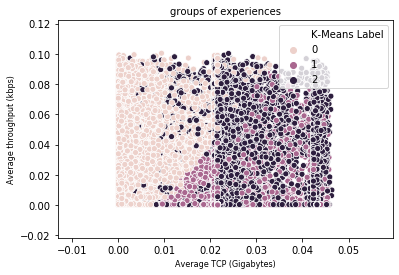

In [21]:
f, ax = plt.subplots()
sns.scatterplot(x ='Average TCP (Gigabytes)' ,y = 'Average throughput (gbps)', hue = 'K-Means Label', data=data, color="b")
ax.set_title('groups of experiences', fontsize=10)
ax.set_xlabel('Average TCP (Gigabytes)', fontsize=8)
ax.set_ylabel('Average throughput (kbps)', fontsize=8)
plt.show()

In [22]:
adata = data.copy()

In [23]:
adata = adata[['MSISDN/Number', 'Number of sessions', 'Average TCP (Gigabytes)','Average RTT (ms)', 'Average throughput (gbps)']]

In [24]:
#function to normalize dataset
def spec_normalize(dataset):
    un_dataset = dataset.iloc[:,1:].values
    min_max_scaler = preprocessing.MinMaxScaler()
    dataset_scaled = min_max_scaler.fit_transform(un_dataset)
    n_dataset = pd.DataFrame(dataset_scaled,columns =[dataset.iloc[:,1:].columns] )
    n_dataset['MSISDN/Number'] = dataset['MSISDN/Number']
    return n_dataset

In [25]:
norm_adata = spec_normalize(adata)

In [26]:
points = norm_adata.drop(['MSISDN/Number'], axis=1)

kmeans = cluster.KMeans(n_clusters=3, random_state=0).fit(points)
norm_adata['cluster'] = kmeans.labels_

centroids = kmeans.cluster_centers_
dists = pd.DataFrame(
    sdist.cdist(points, centroids), 
    columns=['dist_{}'.format(i) for i in range(len(centroids))],
    index=norm_adata.index)

x = pd.concat([norm_adata,dists], axis=1, ignore_index=True)
x = x.rename(columns={0: "Number of sessions", 1: "Average TCP (Gigabytes)",2: "Average RTT (ms)", 3:"Average throughput (kbps)", 4: "MSISDN/Number",5: "K-Means Label", 6: "dist_tcp",7: "dist_rtt",8: "dist_throughput"})

C:\Users\smwik\Anaconda3\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [27]:
export = x[['MSISDN/Number','K-Means Label','dist_tcp','dist_rtt','dist_throughput']]

In [28]:
export.to_csv('data/user_experience.csv') 

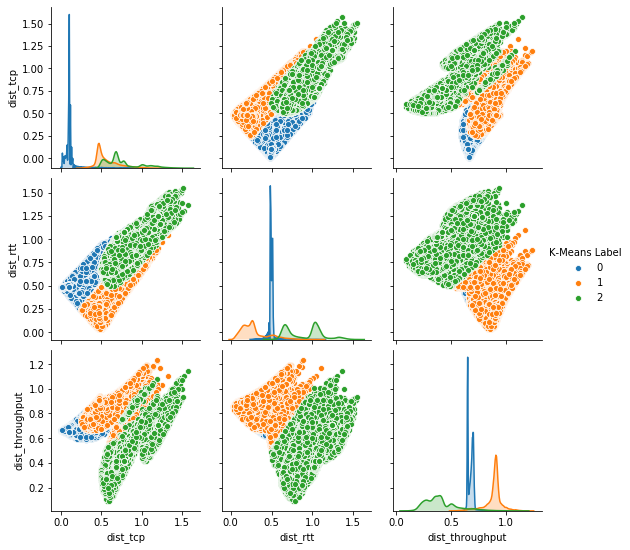

In [29]:
sns.pairplot(data=export.iloc[:,1:],hue = 'K-Means Label')
plt.show()